# 'aliens' in newspapers

In [43]:
import pandas as pd
import altair as alt
from IPython.display import display, HTML, FileLink, clear_output
import nltk
import re
nltk.download('stopwords')
nltk.download('punkt')
stopwords = nltk.corpus.stopwords.words('english')
alt.renderers.enable('notebook')
alt.data_transformers.enable('json')

[nltk_data] Downloading package stopwords to /Users/tim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/tim/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


DataTransformerRegistry.enable('json')

In [44]:
def make_word_sets(words=[], position=None, distance=None):
    dfs = []
    if position and distance:
        if position == 'before':
            distance = 0 - distance
        elif position == 'after':
            distance = distance - 1
    if words:
        for word in words:
            if position and distance is not None:
                new_df = df.loc[df[position].apply(lambda x: x[distance] == word)].copy()
            elif position:
                new_df = df.loc[df[position].apply(lambda x: word in x)].copy()
            elif distance:
                new_df = df.loc[df['before'].apply(lambda x: x[0 - distance].lower() == word) | df['after'].apply(lambda x: x[distance - 1] == word)].copy()
            else:
                new_df = df.loc[df['before'].apply(lambda x: word in x) | df['after'].apply(lambda x: word in x)].copy()
            new_df['word'] = word
            dfs.append(new_df[['date', 'article_id', 'newspaper_id', 'word', 'kwic']])
    elif position and distance is not None:
        new_df = df.copy()
        new_df['word'] = new_df.apply(lambda row: row[position][distance].lower(), axis=1)
        dfs.append(new_df[['date', 'article_id', 'newspaper_id', 'word', 'kwic']])
    return pd.concat(dfs, ignore_index=True)

## Load the data

In [45]:
# Load aliens data from DropBox (it's big)
df = pd.read_csv('https://www.dropbox.com/s/m9md8hw9yprwuuq/newspapers-1548372464-aliens-words-5.csv?dl=1', parse_dates=['date'])
df['before'] = df['before'].str.lower().str.split('|')
df['after'] = df['after'].str.lower().str.split('|')
df.dropna(inplace=True)

In [46]:
df.head()

,article_id,newspaper_id,date,kwic,before,after
0,58444048,89,1911-07-04,"lson was declared a draw. During Ust year 476,...","[during, ust, year, 476, 083]","[ust, year, 476, 083, aliens]"
1,199421680,809,1905-11-11,o doubt that the conditions under which groups...,"[conditions, under, which, groups, of]","[in, lie, past, had, been]"
2,9693820,10,1904-11-26,"ing Chinese labour, fiscal re- form, exclusion...","[fiscal, re, form, exclusion, of]","[and, the, edu, cation, bill]"
4,247920031,1347,1942-03-27,"CANBERRA, Thursday.— Immediate internment of ...","[thursday, immediate, internment, of, all]","[except, na, tionals, of, allied]"
5,247920031,1347,1942-03-27,"Fadden) tonight. . ""The activities of women en...","[the, activities, of, women, enemy]","[should, be, investigated, and, re]"


In [47]:
# Get a count of articles per year
counts = df['date'].groupby([df.date.dt.year]).agg('count').to_frame()
counts.columns = ['count']
counts = counts.reset_index()

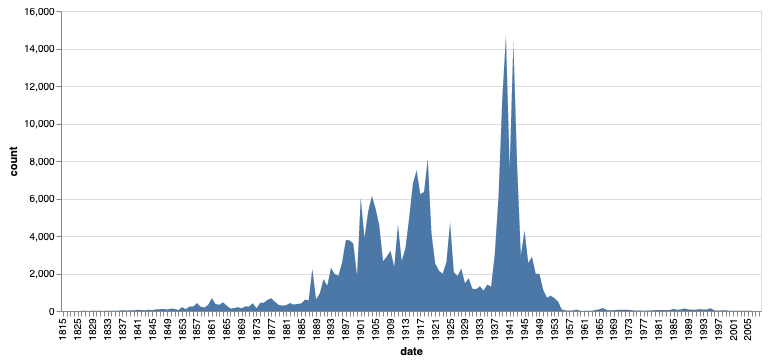

In [48]:
alt.Chart(counts).mark_area().encode(
    x='date:O',
    y='count:Q'
).properties(
    width=700
)

## Word before

In [49]:
word_before_df = make_word_sets(position='before', distance=1)

In [50]:
word_before_df['word'].value_counts()[:20]

of             37920
the            23385
enemy          22023
to              8642
all             6204
by              5371
other           4579
that            4096
and             4067
colored         4033
these           3870
coloured        3774
as              3692
undesirable     3541
with            2563
for             2271
asiatic         2068
000             1871
friendly        1705
are             1647
Name: word, dtype: int64

In [51]:
word_before_df = word_before_df.loc[word_before_df['word'].apply(lambda x: (x.lower() not in stopwords) and len(x) > 2)]

In [52]:
word_before_df['word'].value_counts()[:25]

enemy            22023
colored           4033
coloured          3774
undesirable       3541
asiatic           2068
000               1871
friendly          1705
tho               1581
many              1558
naturalised       1533
interned           889
security           829
exclude            769
refugee            708
civil              691
destitute          676
african            641
pauper             615
unnaturalised      578
prevent            571
two                545
certain            537
desirable          472
dangerous          451
white              421
Name: word, dtype: int64

In [53]:
adjectives = ['enemy', 'colored', 'undesirable', 'asiatic', 'friendly', 'refugee', 'destitute', 'pauper', 'refugee']

In [54]:
adjs_df = make_word_sets(adjectives, position='before', distance=1)
adjs_df = adjs_df.replace('coloured', 'colored')

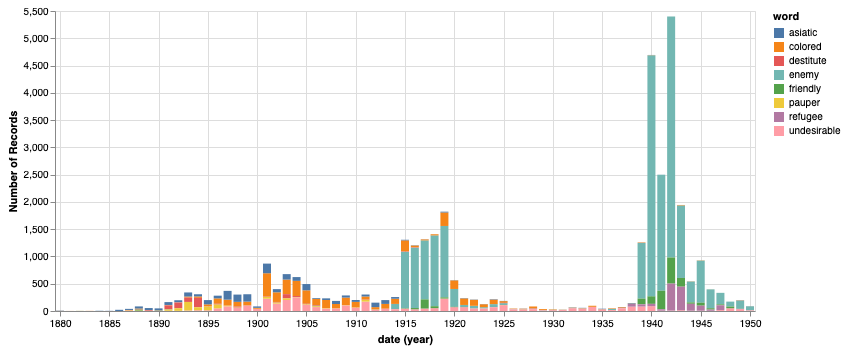

In [55]:
c1 = alt.Chart(adjs_df).mark_bar(size=8).encode(
    x='year(date):T',
    y=alt.Y('count():Q'),
    color='word'
).properties(
    width=700
).transform_filter(
    {'and': [
        alt.FieldRangePredicate(field='date', range=[1880, 1950], timeUnit='year'),
        #alt.FieldOneOfPredicate(field='word', oneOf=['colored', 'undesirable', 'asiatic', 'illegal'])
    ]}
)
c1

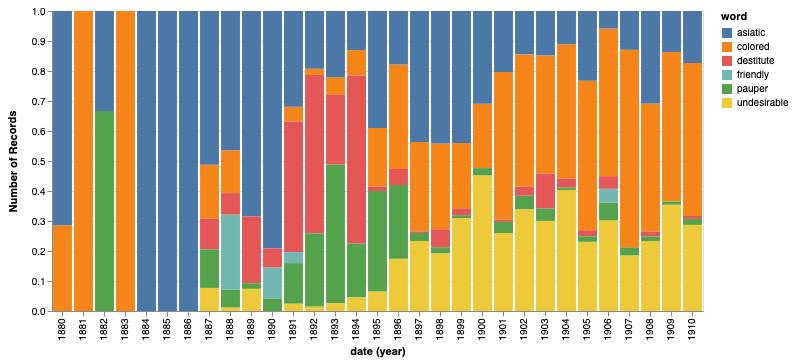

In [56]:
c2 = alt.Chart(adjs_df).mark_bar().encode(
    x='year(date):N',
    y=alt.Y('count():Q', stack='normalize'),
    color=alt.Color('word:N')
).properties(

).transform_filter(
    {'and': [
        alt.FieldRangePredicate(field='date', range=[1880, 1910], timeUnit='year'),
        #alt.FieldOneOfPredicate(field='word', oneOf=['colored', 'undesirable', 'asiatic', 'illegal'])
    ]}
)
c2

In [57]:
nat_df = make_word_sets(['naturalised', 'naturalized'], position='before', distance=1)

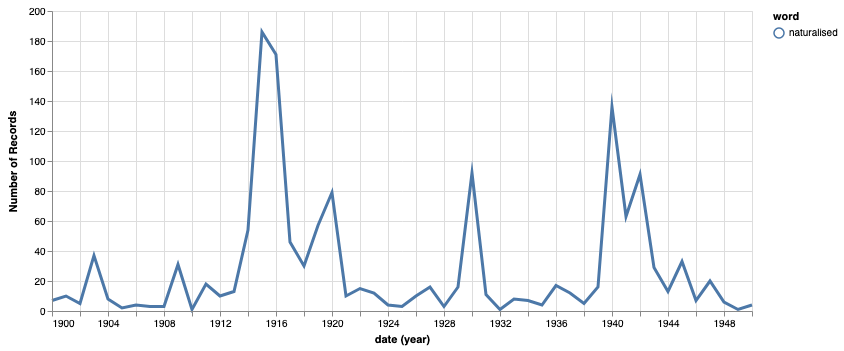

In [58]:
c4 = alt.Chart(nat_df.replace('naturalized', 'naturalised')).mark_line(strokeWidth=3).encode(
    x='year(date):T',
    y=alt.Y('count():Q'),
    color='word'
).properties(
    width=700
).transform_filter(
    {'and': [
        alt.FieldRangePredicate(field='date', range=[1900, 1950], timeUnit='year'),
        #alt.FieldOneOfPredicate(field='word', oneOf=['colored', 'undesirable', 'asiatic', 'illegal'])
    ]}
)
c4

## Words after

In [59]:
word_after_df = make_word_sets(position='after', distance=1)
word_after_df = word_after_df.loc[word_after_df['word'].apply(lambda x: (x.lower() not in stopwords) and len(x) > 2)]

In [60]:
word_after_df['word'].value_counts()[:25]

act             3544
bill            3143
registration    2607
restriction     2245
would           1916
control         1231
must            1150
employed         904
may              838
immigration      778
could            731
corps            697
whose            660
including        589
interned         537
resident         520
tho              507
naturalised      506
within           501
without          499
entering         480
shall            433
coming           430
aliens           409
service          382
Name: word, dtype: int64

In [61]:
top_after_df = make_word_sets(['registration', 'restriction', 'control', 'employed'], position='after', distance=1)

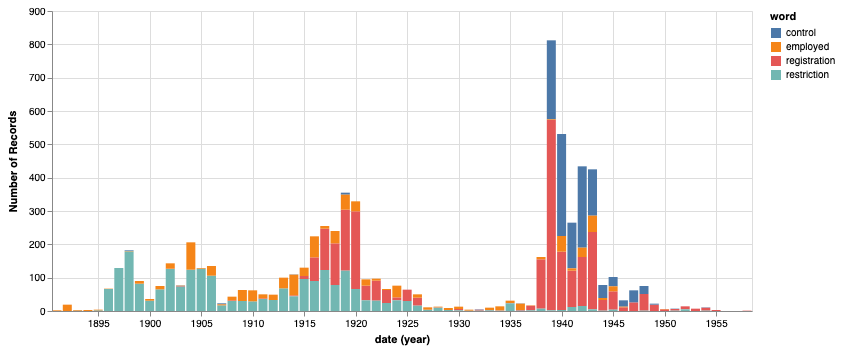

In [62]:
alt.Chart(top_after_df).mark_bar(size=9).encode(
    x='year(date):T',
    y=alt.Y('count():Q'),
    color='word'
).properties(
    width=700
).transform_filter(
    {'and': [
        alt.FieldRangePredicate(field='date', range=[1890, 1960], timeUnit='year'),
        #alt.FieldOneOfPredicate(field='word', oneOf=['colored', 'undesirable', 'asiatic', 'illegal'])
    ]}
)